<a href="https://colab.research.google.com/github/eduardodacostasoares/pytorch/blob/main/04_pytorch_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04 - Pytorch Custom Datasets

Datasets used are given by own PyTorch.

Custom datasets are datasets created or taken by the developer (for example downloading from Kaggle)

## Domain libraries

Depending on what you're working on, vision, text, audio or recommendation, you'll want to lkook into each of the PyTorch domain libraries for existing data loading functions or customizable data loading functions.

**Ressources**
* Book version of the course materials for Custom datasets: https://www.learnpytorch.io/04_pytorch_custom_datasets/


## 4.1 - Importing Pytorch and setting up device agnostic code

In [ ]:
import torch
from torch import nn

torch.__version__

'2.5.1+cu121'

In [ ]:
# Setup device agnostic code

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
device

'cuda'

In [ ]:
!nvidia-smi

Thu Dec  5 15:43:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8              13W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 4.2 - Get data

The custom dataset is a subset of Food101 dataset.

Food101 starts 101 different classes of food and 1000 images per class (750 training, 250 testing).

The custom dataset starts with 3 classes of food and only 10% of the images (75 training, 25 testing)


*Why do this?*
* When starting out ML projects, it's important to try things on a small scale and then increase scale when necessary.

* The whole point is to speed up how fast you can experiment.

In [ ]:
import requests # the custom dataset will be downloaded from GitHub
import zipfile # because the data is in form of zip file
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, dowload it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory already exists... skipping download.")
else:
  print(f"{image_path} does not exist, creating one... ")
  image_path.mkdir(parents=True, exist_ok=True)

# Download
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading 'pizza_steak_sushi' data...")
  f.write(request.content)

# Unzipping pizza, steak and sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("unzipping pizza, steak and sushi data...")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi does not exist, creating one... 
unzipping pizza, steak and sushi data...


In [ ]:
image_path

PosixPath('data/pizza_steak_sushi')

## 4.3 - Data preparation and exploration

In [ ]:
import os
def walk_through_dir(dir_path):
  """Wlak through dir_path return its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories {len(filenames)} images in '{dirpath}'.")

In [ ]:
walk_through_dir(image_path)

There are 2 directories 0 images in 'data/pizza_steak_sushi'.
There are 3 directories 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 3 directories 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories 72 images in 'data/pizza_steak_sushi/train/sushi'.


In [ ]:
# Setup train and testing paths

train_dir =  image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 4.3.1 - Visualizing the data

1. Get all of the image paths
2. Pick a random image path using Python's random.choice;
3. Get the class name using `pathlib.Path.parent.stem`;
4. Open the image with Python's PIL (Python Image Library);
5. Show the image and print metadata.


data/pizza_steak_sushi/test/sushi/1600999.jpg
sushi
Random image path: data/pizza_steak_sushi/test/sushi/1600999.jpg
Image class: sushi
Image heigh: 484
Image width: 512


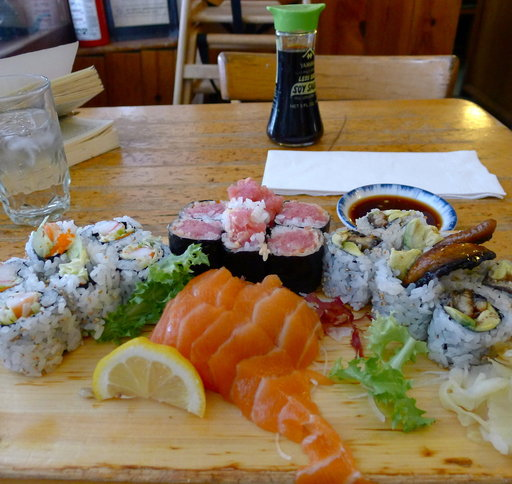

In [ ]:
import random
from PIL import Image

#random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get the image class from path name (name of the directory where the image is stored)
image_class = random_image_path.parent.stem
print(image_class)

# 4. Open image
img = Image.open(random_image_path)

# 5.  Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image heigh: {img.height}")
print(f"Image width: {img.width}")
img

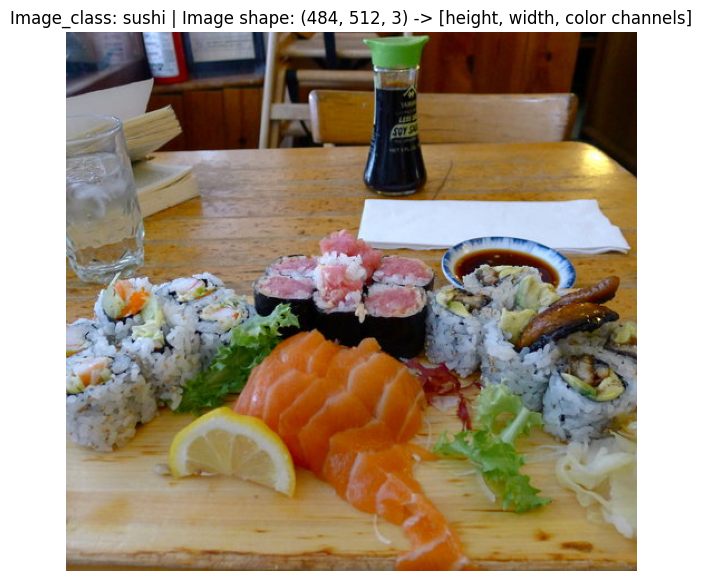

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Turn image into array

img_as_array = np.array(img)

# Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image_class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color channels]")
plt.axis(False);

## 4.4 - Transforming Data

1. Turn target data into tensors (numerical representation of images);
2. Turn it into a `torch.utils.data.Dataset` and subsenquently a `torch.utils.data.DataLoader` (`Dataset` and `DataLoader`);




In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 4.4.1 - Transforming data with `torchvision.transform`

* Transforms help you get your images ready to be used with a model/perform data augmentation.

In [ ]:
# Write a transform for image
data_transform = transforms.Compose([     # to combine transforms (or 'nn.Sequential' can be used)
  # Resize images to 64x64 ()
  transforms.Resize(size=(64, 64)),
  # Flip the images randomly(form of data augumentation) on the horizontal
  transforms.RandomHorizontalFlip(p=0.5),
  # Turn the image into a torch.tensor
  transforms.ToTensor()
])

In [ ]:
data_transform(img)

tensor([[[0.2549, 0.3059, 0.3569,  ..., 0.2000, 0.1882, 0.1686],
         [0.2157, 0.2431, 0.2980,  ..., 0.1961, 0.1765, 0.1569],
         [0.2471, 0.2196, 0.2549,  ..., 0.1843, 0.1608, 0.1412],
         ...,
         [0.6745, 0.6824, 0.6941,  ..., 0.6353, 0.6392, 0.6157],
         [0.5608, 0.5725, 0.5765,  ..., 0.6235, 0.6431, 0.6353],
         [0.4588, 0.4667, 0.4706,  ..., 0.5412, 0.5373, 0.5216]],

        [[0.3137, 0.3137, 0.3294,  ..., 0.1020, 0.0941, 0.0706],
         [0.2824, 0.2824, 0.2863,  ..., 0.0980, 0.0824, 0.0627],
         [0.3216, 0.2745, 0.2549,  ..., 0.0902, 0.0706, 0.0549],
         ...,
         [0.6275, 0.6275, 0.6314,  ..., 0.5255, 0.5176, 0.4824],
         [0.4980, 0.5098, 0.5020,  ..., 0.4824, 0.4980, 0.4824],
         [0.3412, 0.3529, 0.3608,  ..., 0.4118, 0.4196, 0.3882]],

        [[0.4000, 0.3725, 0.3686,  ..., 0.0078, 0.0039, 0.0039],
         [0.3804, 0.3490, 0.3216,  ..., 0.0039, 0.0039, 0.0039],
         [0.4196, 0.3294, 0.2902,  ..., 0.0039, 0.0078, 0.

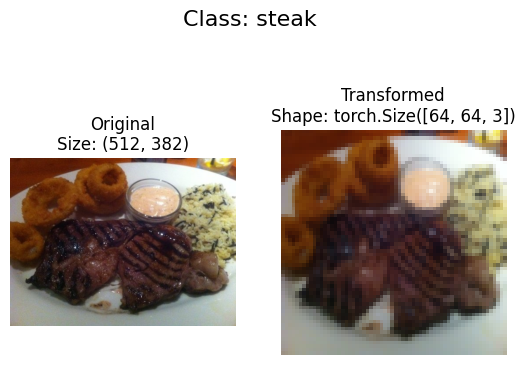

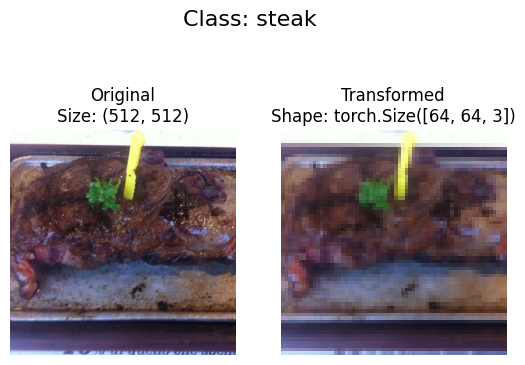

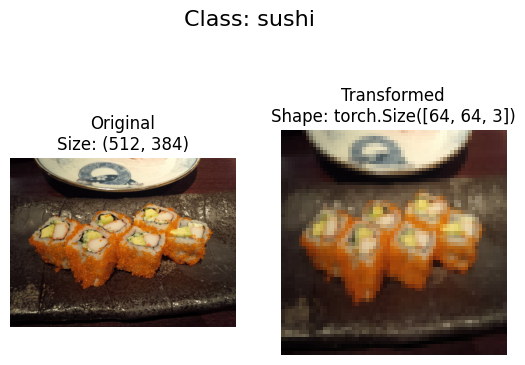

In [ ]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  """
  Selects random images from a path of images and loads/transform
  the original vs the transformed image.
  """

  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1,2,0) #need to change the shape for matplotlib (using '.permute()' ) => (C, H, W)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=None)

## 4.5 - Option 1: Loading image data using `ImageFolder`.

We can load image classification data using `torchvision.datasets.ImageFolder`

* `ImageFolder` documentation: https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html

In [ ]:
# Using ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # a transform for the data ()
                                  target_transform=None)    # transform for the label/target (it's optional)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)


train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [ ]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [ ]:
# Get class names as dictionary
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
# Check the lenghts of our dataset
len(train_data), len(test_data)

(225, 75)

In [ ]:
# Index on the train data_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
img, label
print(f"Image Tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"ILabel datatype: {type(label)}")

Image Tensor:
 tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.0

Original shape: torch.Size([3, 64, 64]) -> [Color_channels, Height, Width]
Image permuted: torch.Size([64, 64, 3]) -> [Height, Width, Color_channels]


Text(0.5, 1.0, 'pizza')

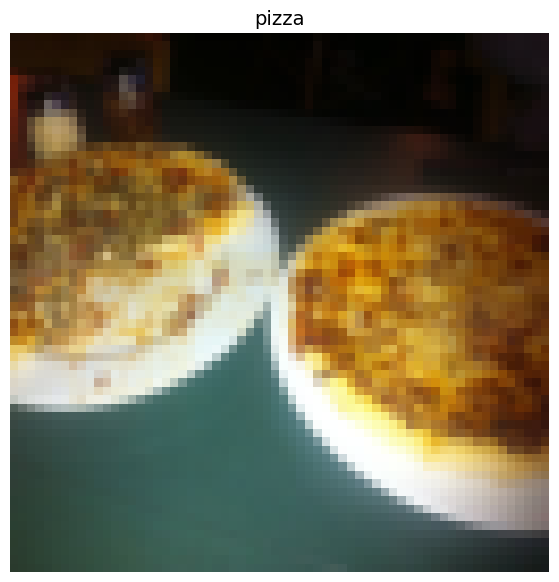

In [ ]:
# Rearrange the order of dimensions - Actual format: (Color_channels, Height, Width)
img_permute = img.permute(1, 2, 0)

# Print out different shapes
print(f"Original shape: {img.shape} -> [Color_channels, Height, Width]")
print(f"Image permuted: {img_permute.shape} -> [Height, Width, Color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

### 4.5.1 - Turn loaded images into `Dataloader`'s

A `Dataloader` is going to help us turn our `Dataset`'s into iterables and we can customise the `batch_size` so our model can see `batch_size` images at a time.

In [ ]:
# Turn train and test datasets into DataLoader's
from torch.utils.data import DataLoader
BATCH_SIZE=1

train_dataloader = DataLoader(dataset=train_data,
                              batch_size = BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)


train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f7334be0d60>,
 <torch.utils.data.dataloader.DataLoader at 0x7f7334be15a0>)

In [ ]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [ ]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1
print(f"Image shape: {img.shape} -> [batch size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch size, color_channels, height, width]
Label shape: torch.Size([1])


## 4.6 - Option 2: Loading Image Data with a Custom `Dataset`:

1. Want to be able to load images from file;
2. Want to be able to get class names from the Dataset;
3. Want to be able to get classes as dictionary from the Dataset.

Pros:
* Can create a `Dataset`out of almost anything
* NOT limited to PyTorch pre-built `Dataset`fucntions.

Cons:
* Even though you could create `Dataset` out of almost anything, **it doesn't mean it will work**.

* Using a custom `Dataset` often results in writing more code, which could be prone to errors or performance issues

In [ ]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [ ]:
# Instance of torchvision.datasets.ImageFolder() - Loading images from file
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 4.6.1 - Creating a helper function to get class names:

A function to:
1. Get the class names using `os.scandir()` to traverse a target dfirectory (ideally the directory is in standard image classification format);

2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory);

3. TUrn the class names into a dictionary and a list and return them.


In [ ]:
# Setup path for target directory
target_directory = train_dir
print(f"Target directory: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target directory: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [ ]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str,int]]:
  """Finds the class folder name in a target directory"""
  # 1. Get the class names by scanninbg the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
  # 2. Raise error if class names could not be founmd
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}. Please, CHECK THE FILE STRUCTURE.")

  # 3. Create a dictionary of index labels
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

In [ ]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 4.6.2 - Create a custom dataset to replicate the ImageFolder

To create a custom dataset:

1. Subclass `torch.utils.data.Dataset`;

2. Init the subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform the data;

3. Create several attributes:
  * paths - paths of the images;
  * transform - the transform to use;
  * classes - a list of the target classes;
  * class_to_idx - a dict of the target classes mapped to integer labels.

4. Create a function to `load.images()`, to open an image;

5. Overwrite the `__len()__`method to return the lenght of the dataset;

6. Overwrite the `__getitem()__` method to return a given sample when passed an index.

In [ ]:
# Write a custom dataset class

from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Initialize the custom Dataset
  def __init__(self,
               targ_dir: str,
               transform=None):
    # 3. Create class attributes
    # Get all of the image paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # Setup transform
    self.transform = transform
    # Create classes and class_to_idx
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Create a function to load images
  def load_image(self, index: int) -> Image.Image:
    """Opens an image via path and returns it"""
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len__()
  def __len__(self) -> int:
    return len(self.paths)

  # 6. Overwrite __getitem__() method to return a particular sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Returns one sample of data, data and labels (X, y)"
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx # return data, label (X, y)
    else:
      return img, class_idx   # return untrasnformed image


In [ ]:
# Create a transform
from torchvision import transforms
train_transforms = transforms.Compose([transforms.Resize(size=(64,64)),
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.ToTensor()
])

test_transforms = transforms.Compose([transforms.Resize(size=(64,64)),
                                      transforms.ToTensor()
])

In [ ]:
# Test out ImageFolderCustom()

train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)

In [ ]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7f733525bf10>,
 <__main__.ImageFolderCustom at 0x7f7335259d50>)

In [ ]:
len(train_data), len(train_data_custom)

(225, 225)

In [ ]:
len(test_data), len(test_data_custom)

(75, 75)

In [ ]:
# Check for equality between orignal ImageFolder Dataset and ImageFolderCustom Dataset

print(train_data_custom.classes==train_data.classes)
print(test_data_custom.classes==test_data.classes)

True
True


### 4.6.3 - Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize;

2. To prevent the display getting out of hand, the number of images will be capped to see at 10;

3. Set the random seed for reproducibility;

4. Get a list of random simplen indexes from the target dataset;

5. Setup a matplotlib plot;

6. Loop through the random sample indexes and plot them with matplotlib;

7. Make sure the dimensions of all images line up with matplotlib (Height, Width and Color Channels).

In [ ]:
# Create a function to take in a dataset

def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  # 2. Adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print("For display purposes, 'n' shouldn't be larger than 10, setting to 10 and removing shape display.")

  # 3. Set the seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # 5. Setup plot
  plt.figure(figsize=(16, 8))

  # 6. Loop through the random sample indexes and plot them with matplotlib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Adjust tensor dimension for plotting
    targ_image_adjusted = targ_image.permute(1, 2, 0) # [Color channels, height, width] --to--> [Height, Width, Color_channels]

    # Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjusted)
    plt.axis("off")
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nShape: {targ_image_adjusted.shape}"
    plt.title(title)

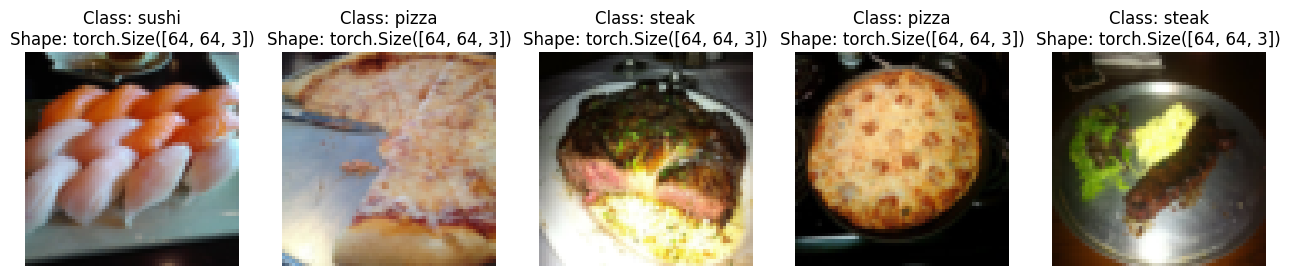

In [ ]:
# Display random images from ImageFolder created dataset
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

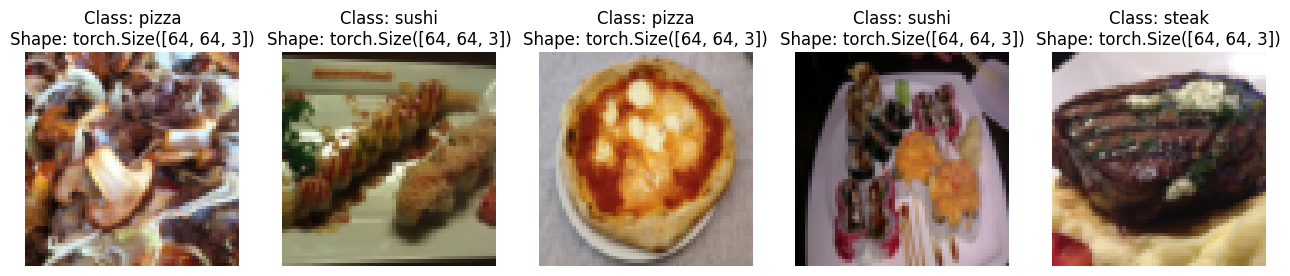

In [ ]:
# Display random images from the ImageFolderCustom dataset

display_random_images(train_data_custom,
                      n=5,
                      classes=class_names,
                      seed=None)

### 4.6.4 - Turcn custom loaded images into DataLoader's




In [ ]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7f7334d30610>,
 <torch.utils.data.dataloader.DataLoader at 0x7f7334220ee0>)

In [ ]:
len(train_dataloader_custom), len(test_dataloader_custom)

(8, 3)

In [ ]:
# Get image and label from custom dataloadeer

img_custom, label_custom = next(iter(train_dataloader_custom))

# Print out the shapes
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 4.7 - Other forms of transforms (data augmentation)

* Data Augmentation is the process of artificially addin diversity to your training data.

In the case of image data, this may mean applying various image transformations to the training images.

This pratice hopefully results in a model that's more generalizable to unseen data.

Looking to one particular type of data augmentation used to train PyTorch vision models to state of the art levels...

Blogpost: https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/

In [ ]:
# Trivail Augment
from torchvision import transforms

train_transform = transforms.Compose([transforms.Resize(size=(224,224)),
                                      transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                      transforms.ToTensor()
])

test_transform = transforms.Compose([transforms.Resize(size=(224,224)),
                                     transforms.ToTensor()
])

In [ ]:
# Get all the image paths

image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/steak/673127.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/3424937.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1627703.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/502076.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1285886.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/690177.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/3873283.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/27415.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/966174.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/894825.jpg')]

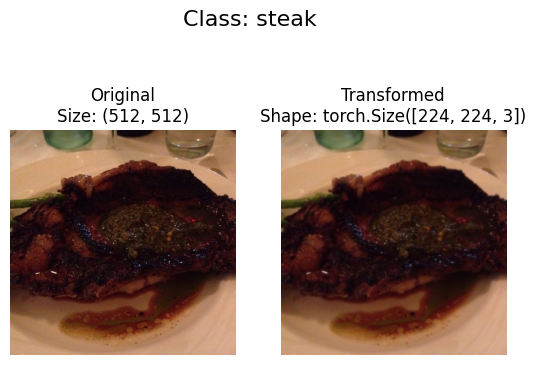

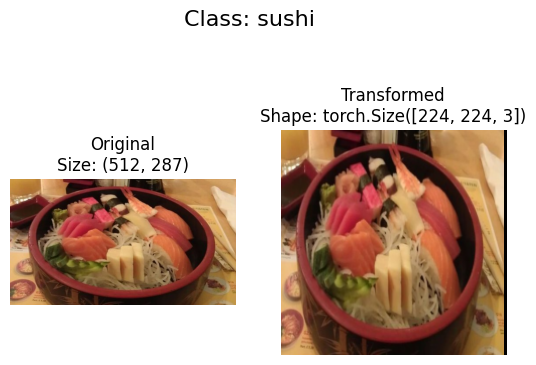

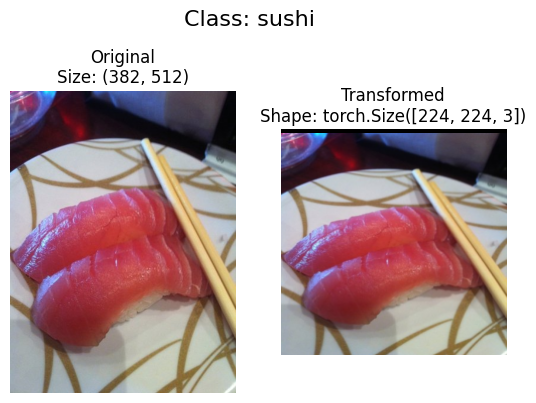

In [ ]:
# Plot random transformed images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,
    seed=None
)

## 4.8 - **Model 0**: TinyVGG without Data Augmentation

### 4.8.1 - Creating transforms and loading data for Model 0

In [ ]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [ ]:
# 1. Load and transform data
from torchvision import datasets
train_data_model0 = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform,
                                         target_transform=None)

test_data_model0 = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

train_data_model0, test_data_model0

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [ ]:
# 2. Turn datasets into DataLoaders
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_model0 = DataLoader(dataset=train_data_model0,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)

test_dataloader_model0 = DataLoader(dataset=test_data_model0,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

train_dataloader_model0, test_dataloader_model0

(<torch.utils.data.dataloader.DataLoader at 0x7f73343e2da0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f73343e3550>)

In [ ]:
len(train_dataloader_model0), len(test_dataloader_model0)

(8, 3)

### 4.8.2 - Create TinyVGG model class

In [ ]:
# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# 3. Creating the CNN Model
class Food101Model0(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*16*16,
                  out_features=output_shape)
    )

  def forward(self, x: torch.Tensor):
    x = self.block_1(x)
    # print(x.shape)
    x = self.block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x
    # return self.classifier(self.block_2(self.block_1(x))) -> benefits from operator fusion

torch.manual_seed(42)

model_0 = Food101Model0(input_shape=3, # number of color_channels in our image data
                       hidden_units=10,
                       output_shape=len(class_names)).to(device)
model_0

Food101Model0(
  (block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

### 4.8.3 - Try a forward pass on a single image (to test the model)

In [ ]:
# get a single image batch
image_batch, label_batch = next(iter(train_dataloader_model0))

image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [ ]:
# Try a forward pass (in_features=10 [number of hidden_units - line 41 of the Class] / )
model_0(image_batch.to(device))

tensor([[0.0578, 0.0634, 0.0351],
        [0.0657, 0.0650, 0.0398],
        [0.0702, 0.0678, 0.0412],
        [0.0687, 0.0646, 0.0417],
        [0.0625, 0.0613, 0.0355],
        [0.0587, 0.0595, 0.0358],
        [0.0634, 0.0637, 0.0376],
        [0.0653, 0.0615, 0.0376],
        [0.0678, 0.0621, 0.0349],
        [0.0620, 0.0599, 0.0371],
        [0.0607, 0.0628, 0.0387],
        [0.0638, 0.0589, 0.0352],
        [0.0658, 0.0611, 0.0369],
        [0.0703, 0.0689, 0.0330],
        [0.0557, 0.0571, 0.0356],
        [0.0632, 0.0642, 0.0388],
        [0.0639, 0.0616, 0.0375],
        [0.0605, 0.0600, 0.0374],
        [0.0623, 0.0627, 0.0368],
        [0.0740, 0.0676, 0.0400],
        [0.0621, 0.0613, 0.0361],
        [0.0632, 0.0599, 0.0366],
        [0.0662, 0.0627, 0.0334],
        [0.0637, 0.0622, 0.0394],
        [0.0670, 0.0666, 0.0363],
        [0.0650, 0.0601, 0.0405],
        [0.0639, 0.0597, 0.0395],
        [0.0733, 0.0687, 0.0412],
        [0.0697, 0.0631, 0.0402],
        [0.062

### 4.8.4 - Use `torchinfo` to get an idea of the shapes going through our model

In [ ]:
# Install and import torchinfo
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary


In [ ]:
summary(model_0, input_size=(BATCH_SIZE, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
Food101Model0                            [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 32, 32]          --
│    └─Conv2d: 2-1                       [32, 10, 64, 64]          280
│    └─ReLU: 2-2                         [32, 10, 64, 64]          --
│    └─Conv2d: 2-3                       [32, 10, 64, 64]          910
│    └─ReLU: 2-4                         [32, 10, 64, 64]          --
│    └─MaxPool2d: 2-5                    [32, 10, 32, 32]          --
├─Sequential: 1-2                        [32, 10, 16, 16]          --
│    └─Conv2d: 2-6                       [32, 10, 32, 32]          910
│    └─ReLU: 2-7                         [32, 10, 32, 32]          --
│    └─Conv2d: 2-8                       [32, 10, 32, 32]          910
│    └─ReLU: 2-9                         [32, 10, 32, 32]          --
│    └─MaxPool2d: 2-10                   [32, 10, 16, 16]          --
├─Sequentia

### 4.8.5 - Create train and test loop functions

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [ ]:
# Creating Train function

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):
  model.train()
  train_loss, train_acc = 0, 0
  model.to(device)
  for batch, (X, y) in enumerate(dataloader):
    # Send data to GPU
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate accuracy without function
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)   # '(y_pred_class==y).sum().item()' takes all elements that are RIGHT PREDICTED and divide by the number of TOTAL PREDICTIONS.

  # Adjusting metrics to get average loss and accuracy per batch
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  return train_loss, train_acc

# TEST
def test_step(dataloader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              device: torch.device = device):
  test_loss, test_acc = 0, 0
  model.to(device)
  model.eval()

  with torch.inference_mode():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)

      # Forward pass
      test_pred = model(X)

      test_loss += loss_fn(test_pred, y)

      test_pred_labels = test_pred.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    return test_loss, test_acc

### 4.8.6 - Create a `train()` function to combine train_step() and test_step()

In [ ]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters + optimizer + dataloader + loss function
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):

  # 2. Create empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)

    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)
    # 4. Print ou what's happening
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc.: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc.: {test_acc:.4f}")

    # 5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # 6. Return the filled results at the end of the epochs
  return results

### 4.8.7 - Train and Evaluate Model_0

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

QT_EPOCHS = 10

model_0 = Food101Model0(input_shape = 3, # number of color channels (R-G-B)
                        hidden_units=10,
                        output_shape=len(train_data.classes)).to(device)

# Loss Function and Optimizer
loss_fn = nn.CrossEntropyLoss() # Multi-class classification data
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

# Starting the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_model0,
                        test_dataloader=test_dataloader_model0,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=QT_EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds.")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1078 | Train acc.: 0.2578 | Test loss: 1.1362 | Test acc.: 0.2604
Epoch: 1 | Train loss: 1.0846 | Train acc.: 0.4258 | Test loss: 1.1622 | Test acc.: 0.1979
Epoch: 2 | Train loss: 1.1153 | Train acc.: 0.2930 | Test loss: 1.1695 | Test acc.: 0.1979
Epoch: 3 | Train loss: 1.0990 | Train acc.: 0.2891 | Test loss: 1.1342 | Test acc.: 0.1979
Epoch: 4 | Train loss: 1.0989 | Train acc.: 0.2930 | Test loss: 1.1433 | Test acc.: 0.1979
Epoch: 5 | Train loss: 1.0965 | Train acc.: 0.3125 | Test loss: 1.1487 | Test acc.: 0.2604
Epoch: 6 | Train loss: 1.1190 | Train acc.: 0.3164 | Test loss: 1.1425 | Test acc.: 0.3333
Epoch: 7 | Train loss: 1.1013 | Train acc.: 0.3516 | Test loss: 1.1046 | Test acc.: 0.1979
Epoch: 8 | Train loss: 1.0890 | Train acc.: 0.4844 | Test loss: 1.0683 | Test acc.: 0.5417
Epoch: 9 | Train loss: 1.0666 | Train acc.: 0.4023 | Test loss: 1.0166 | Test acc.: 0.5417
Total training time: 17.689 seconds.


### 4.8.8 - Plot the Loss curves of model_0

A **loss curve** is a way of tracking your model's progress over time.

https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic?hl=pt-br

In [ ]:
# Get the model_0 results keys

model_0_results.keys(), model_0_results

(dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc']),
 {'train_loss': [1.1078356355428696,
   1.084644928574562,
   1.1152610331773758,
   1.0990339815616608,
   1.0989096909761429,
   1.0965183675289154,
   1.118968203663826,
   1.101346731185913,
   1.0889859199523926,
   1.0666067823767662],
  'train_acc': [0.2578125,
   0.42578125,
   0.29296875,
   0.2890625,
   0.29296875,
   0.3125,
   0.31640625,
   0.3515625,
   0.484375,
   0.40234375],
  'test_loss': [tensor(1.1362, device='cuda:0'),
   tensor(1.1622, device='cuda:0'),
   tensor(1.1695, device='cuda:0'),
   tensor(1.1342, device='cuda:0'),
   tensor(1.1433, device='cuda:0'),
   tensor(1.1487, device='cuda:0'),
   tensor(1.1425, device='cuda:0'),
   tensor(1.1046, device='cuda:0'),
   tensor(1.0683, device='cuda:0'),
   tensor(1.0166, device='cuda:0')],
  'test_acc': [0.2604166666666667,
   0.19791666666666666,
   0.19791666666666666,
   0.19791666666666666,
   0.19791666666666666,
   0.2604166666666667,
   0.3333

In [ ]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """Plot loss curves of Model_0"""
  # Get the loss valus of the result dictionary(training and test)
  loss = results["train_loss"]
  test_loss= results["test_loss"]

  # Get the accuracy values of the result dictionary (training and test)
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # Figure out how many epochs there were
  epochs = range(len(results["train_loss"]))

  # Setupa plot
  plt.figure(figsize=(15,7))

  # Plot loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

In [ ]:
# Sending values to "CPU"

model_0_results['test_loss'] = [x.cpu().item() for x in model_0_results['test_loss']]

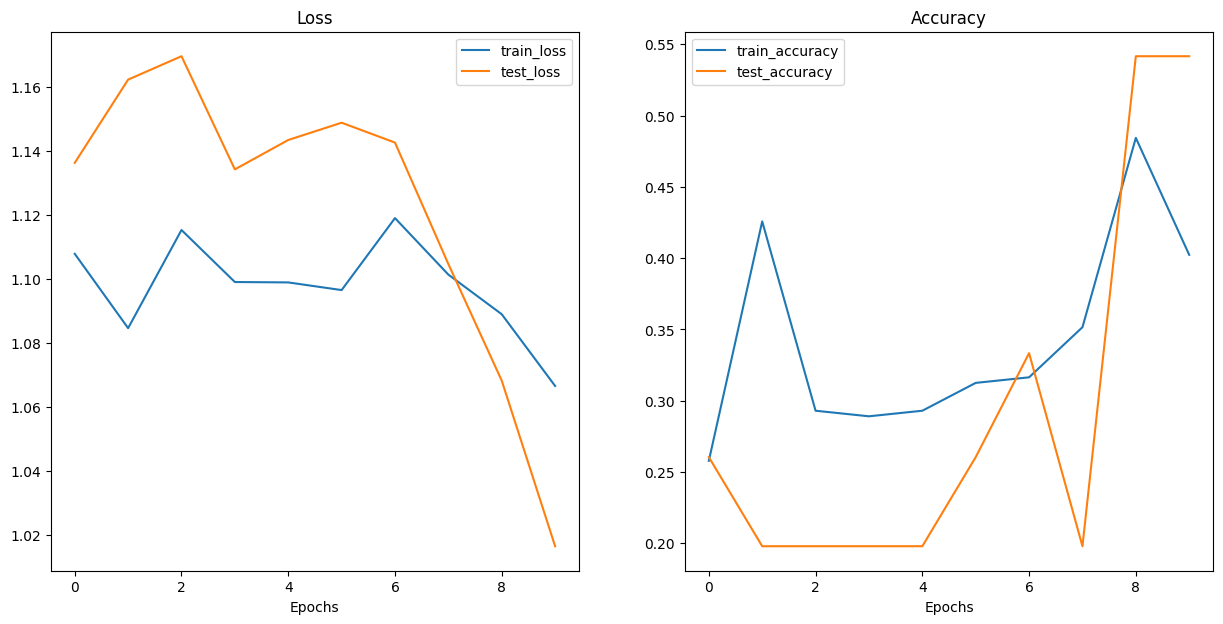

In [ ]:
plot_loss_curves(model_0_results)

## 4.9 - What should an ideal loss curve look like?

A loss curve is one of the most helpful ways to troublshoot a model.


https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic?hl=pt-br

## 4.10 - Model_1: Using Data Augmentation

Modelling experiment, this time, using the same model, with some some data augmentation.

### 4.10.1 - Create transform with data augmentation

In [ ]:
# Create training transform with TriviailAugmentation
from torchvision import transforms

train_transform_trivial = transforms.Compose([
                                              transforms.Resize(size=(64,64)),
                                              transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                              transforms.ToTensor()
])


test_transform_simple = transforms.Compose([
                                            transforms.Resize(size=(64,64)),
                                            transforms.ToTensor()
])

### 4.10.2 - Create train and test `datasets`'s and `DataLoader`'s with Data Augmentation

In [ ]:
# Turn image folders into Datasets
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                             transform=train_transform_trivial)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=test_transform_simple)

In [ ]:
# Turn datasets into DataLoaders
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

### 4.10.3 Construct and train model_1

This time, the model will use the same architecture, but with augmented training data.

In [ ]:
# Create model_1 and send it to the target device
torch.manual_seed(42)

model_1 = Food101Model0(input_shape=3,
                        hidden_units=10,
                        output_shape=len(train_data_augmented.classes)).to(device)

model_1

Food101Model0(
  (block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set epochs
NUM_EPOCHS = 10

# Setup loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

# Start timer
from timeit import default_timer as timer

start_time = timer()

# Train model_1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

# End the timer and print how long it took

end_time = timer()
print(f"Total training time for model_1: {end_time-start_time:.3f} seconds.")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1076 | Train acc.: 0.2500 | Test loss: 1.1062 | Test acc.: 0.2604
Epoch: 1 | Train loss: 1.0791 | Train acc.: 0.4258 | Test loss: 1.1387 | Test acc.: 0.2604
Epoch: 2 | Train loss: 1.0810 | Train acc.: 0.4258 | Test loss: 1.1695 | Test acc.: 0.2604
Epoch: 3 | Train loss: 1.1291 | Train acc.: 0.3047 | Test loss: 1.1622 | Test acc.: 0.2604
Epoch: 4 | Train loss: 1.0901 | Train acc.: 0.4258 | Test loss: 1.1476 | Test acc.: 0.2604
Epoch: 5 | Train loss: 1.0969 | Train acc.: 0.3047 | Test loss: 1.1452 | Test acc.: 0.2604
Epoch: 6 | Train loss: 1.0916 | Train acc.: 0.4609 | Test loss: 1.1465 | Test acc.: 0.1979
Epoch: 7 | Train loss: 1.1016 | Train acc.: 0.2930 | Test loss: 1.1519 | Test acc.: 0.1979
Epoch: 8 | Train loss: 1.1208 | Train acc.: 0.2930 | Test loss: 1.1463 | Test acc.: 0.1979
Epoch: 9 | Train loss: 1.0969 | Train acc.: 0.2930 | Test loss: 1.1141 | Test acc.: 0.2292
Total training time for model_1: 18.890 seconds.


In [ ]:
model_1_results

{'train_loss': [1.1075641214847565,
  1.079112447798252,
  1.0809818804264069,
  1.1291480362415314,
  1.0901155769824982,
  1.096932128071785,
  1.0916281193494797,
  1.1016060560941696,
  1.1208115220069885,
  1.0969125479459763],
 'train_acc': [0.25,
  0.42578125,
  0.42578125,
  0.3046875,
  0.42578125,
  0.3046875,
  0.4609375,
  0.29296875,
  0.29296875,
  0.29296875],
 'test_loss': [tensor(1.1062, device='cuda:0'),
  tensor(1.1387, device='cuda:0'),
  tensor(1.1695, device='cuda:0'),
  tensor(1.1622, device='cuda:0'),
  tensor(1.1476, device='cuda:0'),
  tensor(1.1452, device='cuda:0'),
  tensor(1.1465, device='cuda:0'),
  tensor(1.1519, device='cuda:0'),
  tensor(1.1463, device='cuda:0'),
  tensor(1.1141, device='cuda:0')],
 'test_acc': [0.2604166666666667,
  0.2604166666666667,
  0.2604166666666667,
  0.2604166666666667,
  0.2604166666666667,
  0.2604166666666667,
  0.19791666666666666,
  0.19791666666666666,
  0.19791666666666666,
  0.22916666666666666]}

### 4.10.4 - Plot the loss curves of model_1

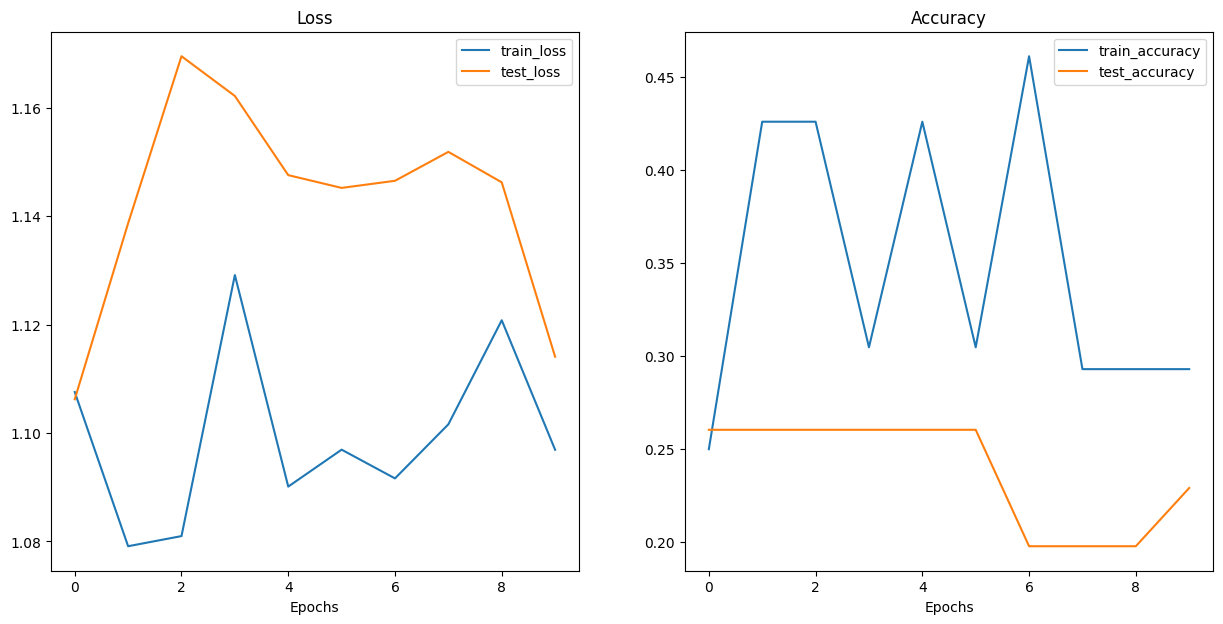

In [ ]:
# Sending values to "CPU" (MatplotLib doesn't accept values in CUDA)
model_1_results['test_loss'] = [x.cpu().item() for x in model_1_results['test_loss']]

plot_loss_curves(model_1_results)

## 4.11 - Compare model results

After evaluating modelling experiments on their own, it's important to compare them to each other.

There's a few different ways to do this:
1. *Hard coding* (what has been done)

2. *PyTorch* + *Tensorboard* - https://pytorch.org/docs/stable/tensorboard.html

3. *Weights & biases* - https://wandb.ai/site/experiment-tracking

4. *MLflow* - https://mlflow.org/

In [ ]:
import pandas as pd

model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_1_df

,train_loss,train_acc,test_loss,test_acc
0,1.107564,0.250000,1.106223,0.260417
1,1.079112,0.425781,1.138703,0.260417
2,1.080982,0.425781,1.169534,0.260417
3,1.129148,0.304688,1.162200,0.260417
4,1.090116,0.425781,1.147591,0.260417
5,1.096932,0.304688,1.145233,0.260417
6,1.091628,0.460938,1.146546,0.197917
7,1.101606,0.292969,1.151884,0.197917
8,1.120812,0.292969,1.146265,0.197917
9,1.096913,0.292969,1.114083,0.229167


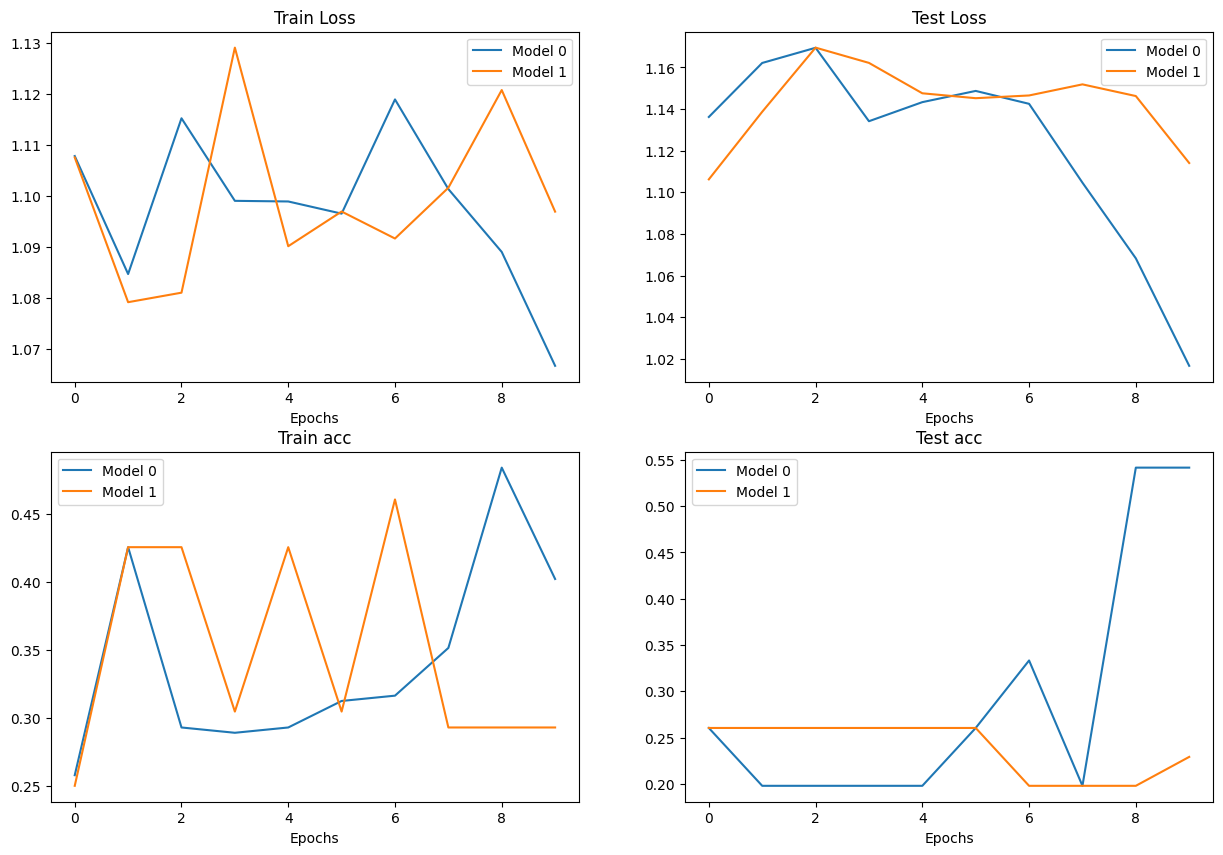

In [ ]:
# Setup a plot

plt.figure(figsize=(15,10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend();

# Plot train Acc
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train acc")
plt.xlabel("Epochs")
plt.legend();

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend();

# Plot train Acc
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test acc")
plt.xlabel("Epochs")
plt.legend();

## 4.12 - Making a prediction on a custom image (Importing custom image from GitHub)


Although the model is trained on a custom data... how to make a prediction on a sample/image that's not in either training or testing dataset.

In [ ]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Downloadthe image from Github if it doesn't already exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    #when downloading an from GitHub, need to use "raw" file link
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists. Skipping download...")

### 4.12.3 - Putting custom image prediction together: building a function

Ideal outcome:

A function where an image path is passed to and have a model predict on a that image and plot the image AND the prediction.